## **Applied Project 2: RLHF**

> **实践方向 (practical track)**  
> 你需要在以下 **OpenAI-Gym** 环境中测试不同的 RLHF 算法：  
> `CartPole`、`MountainCar`、`MountainCarContinuous`、`Acrobot` 以及 `Pendulum` 
> 实验应按下列步骤进行：

---

### **1.Trajectory generation 轨迹生成**

1. **Policy 训练**
   - 训练一个强化学习策略 π₁，使其在目标环境中 **稳定获得接近最高总回报**
   - 保留一个中途模型策略 π₂，使其总回报 `≈ ½` × （最高可达总回报）

2. **构造偏好数据集**  
   - 生成 `K` 对「好的轨迹 / 坏的轨迹」，对于每一对数据：  
     - 用 π₁ 采样得到轨迹 `τ₁`，用 π₂ 采样得到轨迹 `τ₂`
     - 设 `R(τ)` 为轨迹 τ 的总回报，则**以下概率**判定 `τ₁` 为「好的」：  

       $$
       P\bigl(\text{τ₁ 为好的概率}\bigr)=
       \frac{\exp\bigl(R(\tau_1)\bigr)}
            {\exp\bigl(R(\tau_1)\bigr)+\exp\bigl(R(\tau_2)\bigr)}
       $$

---

### **2.Run RLHF 运行RLHF算法**

比较 **DPO**（Direct Preference Optimization）与 **PPO-RLHF**，并在 **至少两个** 上述环境中，针对 **不同规模的偏好数据集** 进行对比实验

> **重要说明**：  
> 每一张结果图都必须报告 **≥ 3 个随机种子** 的平均性能


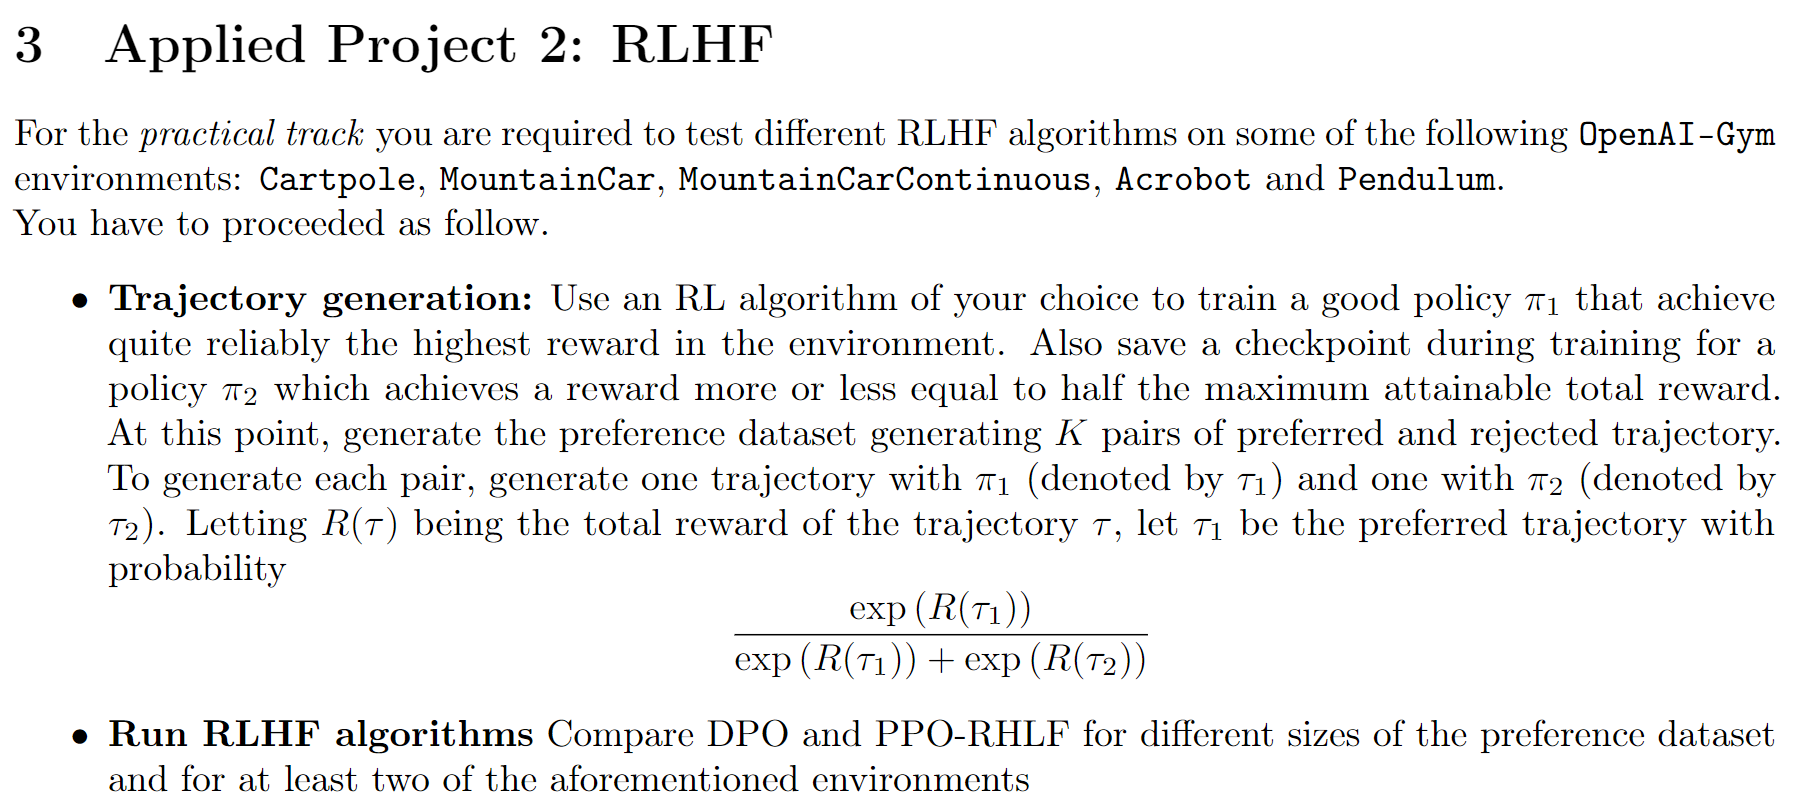

## **Single-Env Training**

In [9]:
import os
import gymnasium as gym
from datetime import datetime
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env
from callback import SaveOnRewardThreshold
import tools

# 设置日志文件夹
# Set the log folder
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

log_path = os.path.join("Training", current_time)
if not os.path.exists(log_path):
    os.makedirs(log_path)


################################################################################################
# 创建 Env
# Create the environment
env = gym.make("CartPole-v1")
env = Monitor(env, filename = os.path.join(log_path, "0.monitor.csv"))    # Monitor the environment for logging
env = DummyVecEnv([lambda: env])                                          # Wrap the environment in a DummyVecEnv


################################################################################################
# 创建 PPO Agent
# Create the PPO agent
model = PPO(policy = "MlpPolicy", 
            env = env, 
            device = "cpu",                  # use device "cpu"                           # 设备类型 "cuda"， 这种情况官方建议使用 cpu
            verbose = 1,                     # Log type                                   # 日志类型
            tensorboard_log = log_path)    # Tensorboard log folder location              # Tensorboard 日志文件夹位置                  

################################################################################################
# 训练暂停的回调函数                         当奖励到达 200 就停止训练
# Callback function to stop training        Stop training when the reward reaches 500
stop_callback = StopTrainingOnRewardThreshold(reward_threshold=500, #0000FF
                                              verbose=1)

# 保存中间模型的回调函数
# Callback function to save intermediate models 
save_callback = SaveOnRewardThreshold(threshold=200,  #0000FF
                                      save_path=os.path.join(log_path))


# 训练评估的回调函数
# Callback function for training evaluation
eval_callback = EvalCallback(env,
                             callback_on_new_best=stop_callback,            # 评估回调函数          # callback function for evaluation
                             best_model_save_path=log_path,                 # 最佳模型保存路径      # Best model save path
                             eval_freq=1000,                                # 每 1000 步评估一次    # Evaluate every 10000 steps
                             n_eval_episodes=20,                            # 评估 20 次            # Evaluate 20 times
                             verbose=1)

print("Log path:  ", log_path, "  \n")

################################################################################################
# 开始训练
# Start training
model.learn(total_timesteps = 20000,    #0000FF
            callback = [eval_callback,  # 添加评估回调函数 # Add evaluation callback function
                        save_callback]  # 添加保存回调函数 # Add save callback function
            )
  
# 保存模型
# Save the model
model_save_path = os.path.join(log_path, "model_full_training")
model.save(model_save_path)

Using cpu device
Log path:   Training\2025-05-04_16-23-24   

Logging to Training\2025-05-04_16-23-24\PPO_1
Eval num_timesteps=1000, episode_reward=9.15 +/- 0.79
Episode length: 9.15 +/- 0.79
---------------------------------
| eval/              |          |
|    mean_ep_length  | 9.15     |
|    mean_reward     | 9.15     |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
New best mean reward!
Eval num_timesteps=2000, episode_reward=9.25 +/- 0.62
Episode length: 9.25 +/- 0.62
---------------------------------
| eval/              |          |
|    mean_ep_length  | 9.25     |
|    mean_reward     | 9.25     |
| time/              |          |
|    total_timesteps | 2000     |
---------------------------------
New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.7     |
|    ep_rew_mean     | 21.7     |
| time/              |          |
|    fps             | 1553     |


## **Multi-Env Training**
Faster then training in single environment

In [6]:
import os
import gymnasium as gym
from datetime import datetime
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3.common.env_util import make_vec_env
from callback import SaveOnRewardThreshold
import tools

In [ ]:
# 设置日志文件夹
# Set the log folder
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

log_path = os.path.join("Training", current_time)
if not os.path.exists(log_path):
    os.makedirs(log_path)


################################################################################################
# 创建 Env
# Create the environment
vec_env = make_vec_env(env_id = "CartPole-v1", 
                       n_envs = 8, 
                       monitor_dir = log_path)      # Create multiple environments and monitor them


################################################################################################
# 创建 PPO Agent
# Create the PPO agent
model = PPO(policy = "MlpPolicy", 
            env = vec_env, 
            n_steps = 256,                   # ← 重点：减小 rollout 长度
            device = "cpu",                  # use device "cpu"                           # 设备类型 "cuda"， 这种情况官方建议使用 cpu
            verbose = 1,                     # Log type                                   # 日志类型
            tensorboard_log = log_path)      # Tensorboard log folder location            # Tensorboard 日志文件夹位置                  

################################################################################################
# 训练暂停的回调函数                         当奖励到达 200 就停止训练
# Callback function to stop training        Stop training when the reward reaches 500
stop_callback = StopTrainingOnRewardThreshold(reward_threshold=500, #0000FF
                                              verbose=1)

# 保存中间模型的回调函数
# Callback function to save intermediate models 
save_callback = SaveOnRewardThreshold(threshold=200,  #0000FF
                                      save_path=os.path.join(log_path))


# 训练评估的回调函数
# Callback function for training evaluation
eval_callback = EvalCallback(vec_env,
                             callback_on_new_best=stop_callback,            # 评估回调函数          # callback function for evaluation
                             best_model_save_path=log_path,                 # 最佳模型保存路径      # Best model save path
                             eval_freq=1000,                                # 每 1000 步评估一次    # Evaluate every 10000 steps
                             n_eval_episodes=20,                            # 评估 20 次            # Evaluate 20 times
                             verbose=1)

print("Log path:  ", log_path, "  \n")

################################################################################################
# 开始训练
# Start training
model.learn(total_timesteps = 50000,    #0000FF
            callback = [eval_callback,  # 添加评估回调函数 # Add evaluation callback function
                        save_callback]  # 添加保存回调函数 # Add save callback function
            )
  
# 保存模型
# Save the model
model_save_path = os.path.join(log_path, "model_full_training")
model.save(model_save_path)

Using cpu device
Log path:   Training\2025-05-04_16-24-35   

Logging to Training\2025-05-04_16-24-35\PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22       |
|    ep_rew_mean     | 22       |
| time/              |          |
|    fps             | 7735     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27.3        |
|    ep_rew_mean          | 27.3        |
| time/                   |             |
|    fps                  | 2406        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.009111373 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    e

In [10]:
# 评估模型
# Test the model
import os; import tools
log_path = "Training\\2025-05-04_16-24-35"
PPO_Model_Path = os.path.join(log_path, "model_full_training")
tools.test_model("PPO", PPO_Model_Path, n_episodes=2, render = True)

Training\2025-05-04_16-24-35\model_full_training
Episode: 1 Score: [463.]
Episode: 2 Score: [260.]


Plotting path is:  Training\2025-05-04_16-24-35


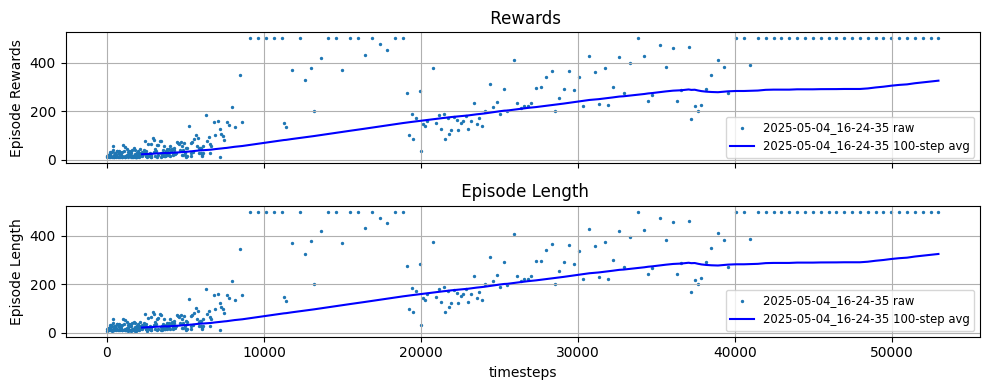

In [18]:
# 绘制结果
# Plotting the results
import tools
print("Plotting path is: ", log_path)
tools.plot_result(dirs=[log_path],
                  window = 100)

# # Plot Multi-Training Results
# tools.plot_result(dirs=["Training\\2025-05-04_16-23-24", "Training\\2025-05-04_16-24-35"],
#                   window = 100)

In [13]:
# print("Plotting path is: ", log_path)
# tools.plot_result(os.path.join(log_path,"PPO_1"))

In [14]:
# !netstat -aon | findstr :6006
# %load_ext tensorboard
# %tensorboard --logdir Training/Logs/PPO_2 --port 6006

## **生成轨迹 Pair**

In [25]:
import os
import pandas as pd
import gym
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from gymnasium.wrappers import RecordVideo

def test_model(model_type, model_path, n_episodes=5, render=False, record=False, traj=False):

    print(model_path)

    # 录像 & csv 路径
    path_list = model_path.split("\\")
    base_dir = "\\".join(path_list[:-1])
    # video_path = os.path.join(base_dir, "videos")
    video_path = os.path.join(base_dir)
    os.makedirs(video_path, exist_ok=True)

    # 根据模型名设定前缀
    name_prefix_ = "Pi-1" if path_list[-1] == "model_full_training.zip" else "Pi-2"

    # 初始化环境的渲染模式
    render_mode = "human" if render else None
    
    if record:
        render_mode = "rgb_array"

    env = gym.make("CartPole-v1", render_mode=render_mode)
    if record:
        env = RecordVideo(
            env,
            video_folder=video_path,
            episode_trigger=lambda ep_id: ep_id < n_episodes,
            name_prefix=name_prefix_
        )
    env = DummyVecEnv([lambda: env])

    print("")

    # 如果要记录轨迹，准备容器
    if traj:
        traj_data = []

    # 加载模型
    if model_type == "PPO":
        model = PPO.load(model_path, device="cpu", env=env)
    elif model_type == "DQN":
        model = DQN.load(model_path, device="cpu", env=env)
    else:
        raise ValueError("Unsupported model type. Use 'PPO' or 'DQN'.")

    # 开始测试
    for ep in range(n_episodes):
        obs = env.reset()           # NOTE: VecEnv reset
        done = False
        score = 0
        step = 0

        while not done:
            action, _ = model.predict(obs)
            obs_next, reward, done, _ = env.step(action)
            score += reward[0]
            
            if traj:
                # 展平 obs（假设 shape=(1,4)），取第 0 个环境
                o = obs[0]
                traj_data.append({
                    "episode": ep + 1,
                    "step": step,
                    "obs_0": float(o[0]),
                    "obs_1": float(o[1]),
                    "obs_2": float(o[2]),
                    "obs_3": float(o[3]),
                    "action": int(action[0]),
                    "reward": float(reward[0])
                })

            obs = obs_next
            step += 1

        print(f"Episode: {ep+1} Score: {score}")

    env.close()

    # 输出轨迹到 CSV
    if traj:
        df = pd.DataFrame(traj_data)
        csv_name = f"{name_prefix_}-trajectory.csv"
        csv_path = os.path.join(base_dir, csv_name)
        df.to_csv(csv_path, index=False)
        print(f"Trajectory saved to: {csv_path}")


In [27]:
from stable_baselines3 import PPO, DQN
import gymnasium as gym
import os

log_path = "Training\\2025-05-04_16-24-35"

model_pi_1_path = os.path.join(log_path, "model_full_training.zip")
model_pi_2_path = os.path.join(log_path, "model_at_reward_200.zip")

model_pi_1 = PPO.load(model_pi_1_path, device="cpu")
model_pi_2 = PPO.load(model_pi_2_path, device="cpu")

test_model("PPO", model_pi_1_path, n_episodes=1, render=False, record=True, traj=True)
test_model("PPO", model_pi_2_path, n_episodes=1, render=True,  record=True, traj=True)

Training\2025-05-04_16-24-35\model_full_training.zip

Episode: 1 Score: 480.0
Trajectory saved to: Training\2025-05-04_16-24-35\Pi-1-trajectory.csv
Training\2025-05-04_16-24-35\model_at_reward_200.zip

Episode: 1 Score: 105.0
Trajectory saved to: Training\2025-05-04_16-24-35\Pi-2-trajectory.csv


In [52]:
# RLHF 
#   需要把所有的 trajectory 裁成一样长输入
#   训练的 RLHF 会根据 trajectory 返回分数

# 加载轨迹数据
import numpy as np
import pandas as pd

df = pd.read_csv("Training\\2025-05-04_16-24-35\\Pi-1-trajectory.csv")

print(type(df))

print(df.columns)

print(df['reward'])            # 取出 reward 列

np.sum(np.array(df['reward'])) # 将 pandas 数据转为 numoy 数组

<class 'pandas.core.frame.DataFrame'>
Index(['episode', 'step', 'obs_0', 'obs_1', 'obs_2', 'obs_3', 'action',
       'reward'],
      dtype='object')
0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
475    1.0
476    1.0
477    1.0
478    1.0
479    1.0
Name: reward, Length: 480, dtype: float64


np.float64(480.0)

In [ ]:
class RLHF_class:
    def __init__(self, path):

        # 读取 CSV 文件
        self.data = pd.read_csv(path)

        self.reward_sequence = np.array(self.data['reward'])


    def compute_total_reward(self):
        return np.sum(self.reward_sequence)
    

Pi1 = RLHF_class("Training\\2025-05-04_16-24-35\\Pi-1-trajectory.csv")
Pi1.compute_total_reward()




np.float64(480.0)